Welcome to assignment 1.                                                       

We are using pathology images for our first assignment please download data from this link https://drive.google.com/drive/folders/10dUOzcPR-PQwfFYcHk5gsLjIjSorQ32Q?usp=sharing



# Task 1: Feature Generation (15%)
# Use and run the following code (a deep network) to generate features from a set of training images. For this assignment, you do not need to know how the deep network is working here to extract features.
# This code extracts the features of image T4.tif (in the T folder of dataset). Modify the code so that it iterates over all images of the dataset and extracts their features.
# Allocate 10% of the data for validation.

# Insert your code here for Task 1





In [3]:
import os
import numpy as np
import random
import torch
import torchvision.transforms as transforms
from torchvision.models import densenet121
from torch.autograd import Variable
from PIL import Image
import matplotlib.pyplot as plt



# Load pre-trained DenseNet model
model = densenet121(weights='DenseNet121_Weights.IMAGENET1K_V1')

# Remove the classification layer (last fully connected layer)
model = torch.nn.Sequential(*list(model.children())[:-1])

# Add a global average pooling layer
model.add_module('global_avg_pool', torch.nn.AdaptiveAvgPool2d(1))

# Set the model to evaluation mode
model.eval()

# Define the image preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset folder
imageNames = []
extractedFeatures = []

#shouldn't need to change the root directory if you pulled correctly
for root, _, files in os.walk('.\\train-20240206T024149Z-001\\train'):
    for file in files:
            imageNames.append(os.path.join(root, file))
            # Load an image
            image_path = os.path.join(root, file)

            # get_image_files(image_path)

            image = Image.open(image_path)

            # Preprocess the image
            input_tensor = preprocess(image)
            input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

            # Wrap the input tensor in a Variable
            input_var = Variable(input_batch)

            # Forward pass through the model
            features = model(input_var)

            # Extract the feature tensor
            feature_vector = features.squeeze().detach().numpy()

            # Now 'feature_vector' contains the feature from the last fully connected layer of DenseNet
            #print("Feature vector shape:", feature_vector.shape)
            # for feature in feature_vector:
            #     print(feature)
            extractedFeatures.append(feature_vector)

#check to see if all images were parsed through
print(len(extractedFeatures))

# Needed to convert to np array. was having issues with just normal list
extractedFeatures = np.array(extractedFeatures)

# Splitting the data
tenPercentLength = int(len(extractedFeatures) * 0.1)
randomIndices = np.random.choice(len(extractedFeatures), size=tenPercentLength, replace=False)

# Extract the elements corresponding to the random indices for test set
validationFeatures = extractedFeatures[randomIndices]
#validationImageNames = [imageNames[i] for i in randomIndices]

# Extract the remaining elements for training set
trainFeatures = np.delete(extractedFeatures, randomIndices, axis=0)
#trainImageNames = [imageNames[i] for i in range(len(imageNames)) if i not in randomIndices]

print('Test Set Length:', len(validationFeatures))
print('Train Set Length:', len(trainFeatures))

780
Test Set Length: 78
Train Set Length: 702


# Task 2: High Bias Classification Method (5%)
# Choose a classification method and let is have a high bias.
# Train it on the generated features and discuss why it is underfitting.

# Insert your code here for Task 2




# Task 3: High Variance Classification Method (5%)
# Use the chosen classification method and let it have a high variance.
# Train it on the generated features and discuss why it is overfitting.

# Insert your code here for Task 3




# Task 4: Balanced Classification Method (15%)
# Use the chosen classification method and let it balance the bias and variance.
# Train it on the generated features, possibly adjusting parameters.
# Discuss insights into achieving balance.

# Insert your code here for Task 4




# Task 5: K-Means Clustering (20%)
# Apply K-Means clustering on the generated features.
# Test with available labels and report accuracy.
# Experiment with automated K and compare with manually set 20 clusters.

# Insert your code here for Task 5




Automated K Value =  27


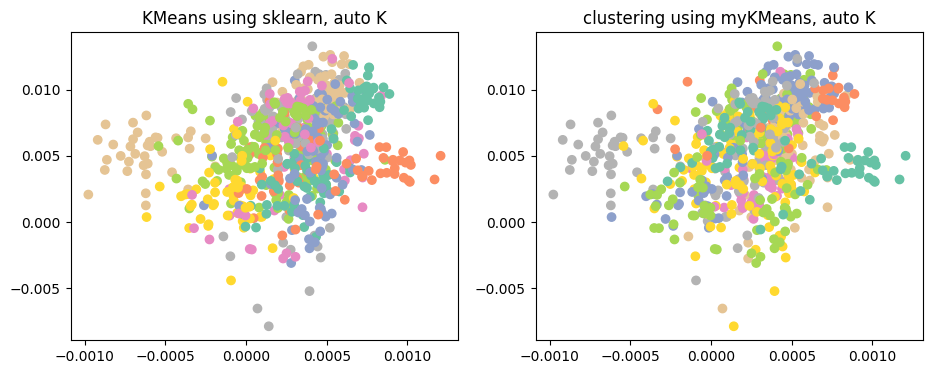

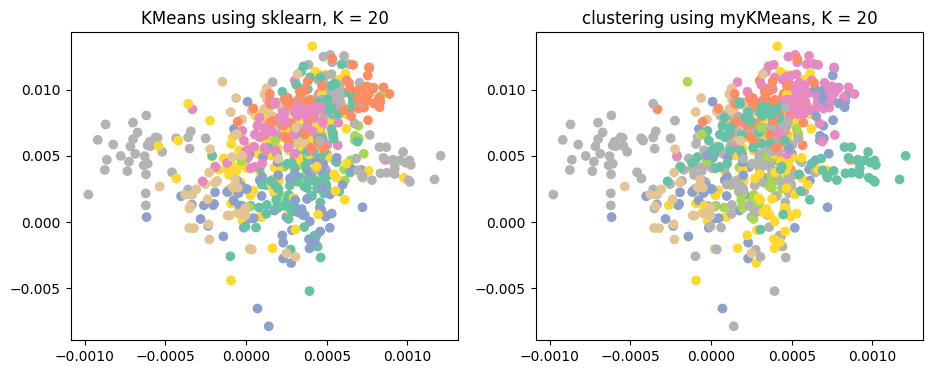

In [23]:
from sklearn.cluster import KMeans
import sklearn

##### HELPER FUNCTIONS #####

# helper function to compute distance from each point to each centroid
def compute_distance_matrix(data, centroids):
    N = len(data)
    K = len(centroids)
    
    # compute sum of squares between each point and each centroid
    SS_matrix = np.random.rand(N,K)
    for k in range(K):
        SS_matrix[:,k] = np.sum((data - centroids[k])**2, axis = 1)
    
    return SS_matrix

# helper function to assign each point to closest centroid
def assign_centroid(SS_matrix):
    N, K = SS_matrix.shape

    # assign each point to closest centroid 
    labels = np.argmin(SS_matrix, axis = 1)
    
    # compute total within cluster sum of squares for the labels
    WCSS = 0
    for k in range(K):
        WCSS += SS_matrix[labels == k, k].sum()

    return labels, WCSS

# helper function to update the centroid location
def update_centroids(data, labels, K):
    N,M = data.shape
    
    # take the mean of each cluster as new centroids
    newcentroids = np.random.rand(K,M)
    for k in range(K):
        newcentroids[k] = data[labels == k].mean(axis = 0)

    return newcentroids

##### KMEANS FUNCTION #####

def myKMeans(data, K=20, threshold = 0.01, max_iterations = 500, random_state = 711):
        
    # initialize centroids
    np.random.seed(random_state)
    centroids = data[np.random.randint(0, data.shape[0], K)]
    prevWCSS = 0

    # loop through assigning labels and updating centroids
    for j in range(max_iterations):    
        
        # assign labels
        SS_matrix = compute_distance_matrix(data, centroids)
        labels, WCSS = assign_centroid(SS_matrix)

        # check stopping
        improvement = prevWCSS - WCSS
        if improvement < threshold and j>0:
            # print('myKMeans stopped after {} iterations.'.format(j+1))
            return labels, WCSS

        # update centroids
        centroids = update_centroids(data, labels, K)
        prevWCSS = WCSS

    return labels, WCSS

##### SETTING K #####

# automated K selection
def autoK(threshold = 100, max_range = 40):
    wcss_all = []

    # compute wcss for K = 1,...,max_range
    krange = range(1,max_range)
    prevWCSS = 0 
    for k in krange:
        labels_k, wcss_k = myKMeans(trainFeatures, K=k)
        wcss_all.append(wcss_k)
        WCSS = wcss_k

        # check stopping
        improvement = abs(prevWCSS - WCSS)
        if improvement < threshold and k>0:
            return k
        prevWCSS = WCSS
        
    return k

# set K
K = autoK()
print("Automated K Value = ", K)

##### MAIN CODE with auto K#####

# sklearn implementaion of kmeans
kmeans = KMeans(n_clusters = K, random_state = 711)
# fit kmeans to train data
kmeans.fit(trainFeatures)
labels = kmeans.labels_

##### NOT WORKING ######

# predict test data
#prediction = kmeans.predict(validationFeatures)
# check accuracy
#accuracy = sklearn.metrics.accuracy_score(labels, prediction)
#print("Accuracy Auto K = ", accuracy)

########################

# myKMeans implementation:
labels_ours, wcss_ours = myKMeans(trainFeatures, K)

# plot sklearn
plt.figure(2,figsize = (11,4))
ax = plt.subplot(121)
plt.scatter(trainFeatures[:,0],trainFeatures[:,1], c=labels, cmap='Set2')
plt.title('KMeans using sklearn, auto K')

# plot myKMeans
ax = plt.subplot(122)
plt.scatter(trainFeatures[:,0],trainFeatures[:,1], c=labels_ours, cmap='Set2')
plt.title('clustering using myKMeans, auto K')
plt.show()

##### MAIN CODE with K = 20 #####

# sklearn implementaion of kmeans
kmeans = KMeans(n_clusters = 20, random_state = 711)
#fit kmeans to train data
kmeans.fit(trainFeatures)
labels = kmeans.labels_

# myKMeans implementation:
labels_ours, wcss_ours = myKMeans(trainFeatures, 20)

# plot sklearn
plt.figure(2,figsize = (11,4))
ax = plt.subplot(121)
plt.scatter(trainFeatures[:,0],trainFeatures[:,1], c=labels, cmap='Set2')
plt.title('KMeans using sklearn, K = 20')

# plot myKMeans
ax = plt.subplot(122)
plt.scatter(trainFeatures[:,0],trainFeatures[:,1], c=labels_ours, cmap='Set2')
plt.title('clustering using myKMeans, K = 20')
plt.show()

# Task 6: Additional Clustering Algorithm (10%)
# Choose another clustering algorithm and apply it on the features.
# Test accuracy with available labels.

# Insert your code here for Task 6




# Task 7: PCA for Classification Improvement (20%)
# Apply PCA on the features and then feed them to the best classification method in the above tasks.
# Assess if PCA improves outcomes and discuss the results.

# Insert your code here for Task 7




# Task 8: Visualization and Analysis (10%)
# Plot the features in a lower dimension using dimentinality reduction techniques.
# Analyze the visual representation, identifying patterns or insights.

# Insert your code here for Task 8